# Test Gene Annotation
Annotate the regions by genes (aligned on hg19)

## 1. Constants

In [1]:
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/esophagus_muscularis_SM-A8CPH.h5ad"
#h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/heart_lv_SM-IOBHO.h5ad"

## 2. Imports

In [2]:
import episcanpy as epi
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 3. Read h5ad files and build anndata objects

In [3]:
adata = epi.read_h5ad(h5ad_path)

## 4. Define find_genes

In [4]:
# from episcanpy 0.4.0 episcanpy/tools/_find_genes.py
def find_genes(adata,
                 gtf_file,
                 key_added='gene_annotation',
                 upstream=5000,
                 downstream=0,
                 feature_type='gene',
                 annotation='HAVANA',
                 raw=False):
    """
    merge values of peaks/windows/features overlapping genebodies + 2kb upstream.
    It is possible to extend the search for closest gene to a given number of bases downstream as well.

    There is commonly 2 set of annotations in a gtf file(HAVANA, ENSEMBL). By default, the function
    will search annotation from HAVANA but other annotation label/source can be specifed.

    It is possible to use other type of features than genes present in a gtf file such as transcripts or CDS.

    """
    ### extracting the genes
    gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])

    # extracting the feature coordinates
    raw_adata_features = {}
    feature_index = 0
    """
    snitz: changed from episcanpy
    this loop expects chr_from_to
    we actually have chr:from-to
    
    for line in adata.var_names.tolist():
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_index]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_index])
        feature_index += 1
    """
    for line in adata.var_names.tolist():
        chromosome, location = line.split(':')
        loc_from, loc_to = location.split('-')
        if chromosome not in raw_adata_features:
            raw_adata_features[chromosome] = [[int(loc_from),int(loc_to), feature_index]]
        else:
            raw_adata_features[chromosome].append([int(loc_from),int(loc_to), feature_index])
        feature_index += 1

    ## find the genes overlaping the features.
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                for gene in gtf[chrom]:
                    if (gene[1]<= feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end <= gene[0]): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))

                if gene_name == []:
                    gene_index.append('intergenic')
                elif len(gene_name)==1:
                    gene_index.append(gene_name[0])
                else:
                    gene_index.append(";".join(list(set(gene_name))))

        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append("unassigned")

    adata.var[key_added] = gene_index

## 5. Download annotations

In [ ]:
# !wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz -O data/gencode.v19.annotation.gtf.gz
# !cd data; gunzip gencode.v19.annotation.gtf

## 6. Annotate the data

In [5]:
# TODO: This step takes quite a while, maybe cache it? 
find_genes(adata,
           gtf_file='data/gencode.v19.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

## 7. Plot Count of Regions per Gene

In [89]:
df = adata.var.groupby("transcript_annotation")["transcript_annotation"].agg(["count"])

In [90]:
df

,count
transcript_annotation,
7SK,58
A1CF,26
A1CF;ASAH2B,2
A2M,19
A2ML1,17
...,...
hsa-mir-7162,15
hsa-mir-7162;RP11-299H22.5,3
hsa-mir-7515,18


In [91]:
print(f'intergenic: {df.loc["intergenic"]["count"]}')
print(f'unassigned: {df.loc["unassigned"]["count"]}')

intergenic: 454612
unassigned: 147


In [92]:
# Drop 'intergenic' and 'unassigned' annotations
df = df.drop("intergenic")
df = df.drop("unassigned")

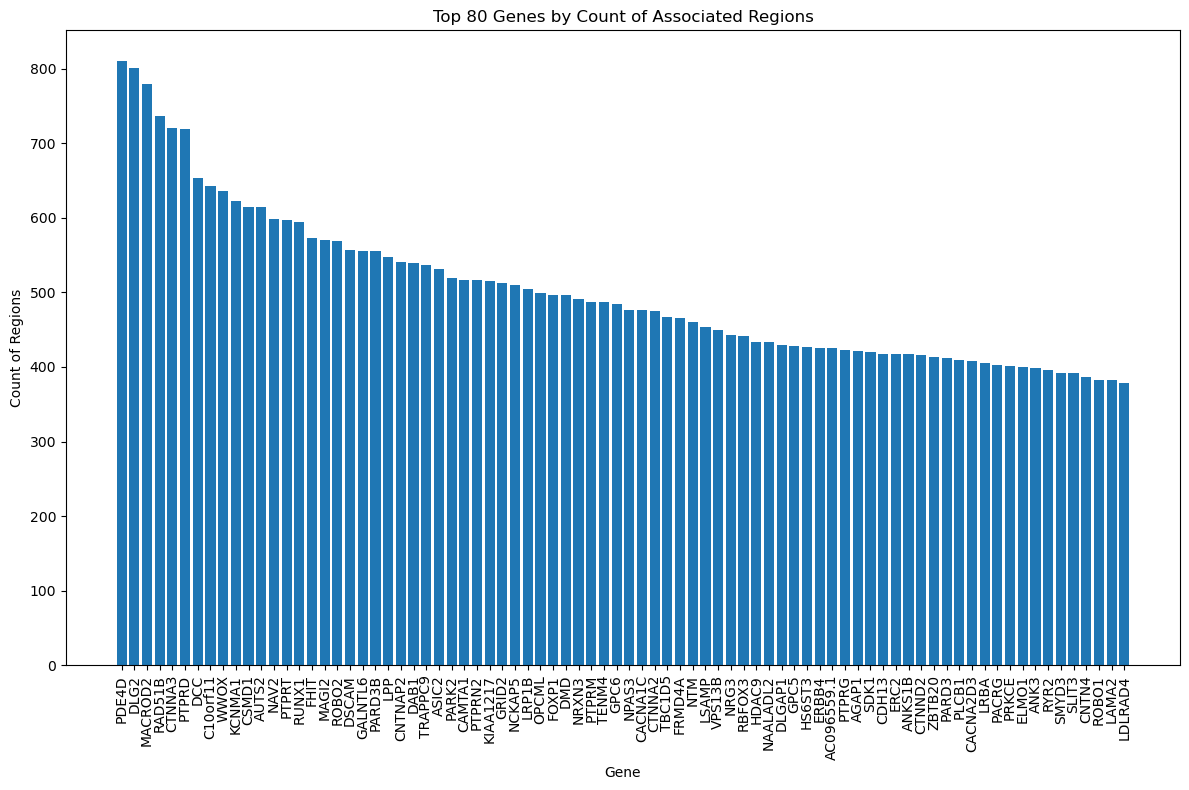

In [93]:
top_n = 80  # Adjust this number as needed
sorted_df = df.sort_values(by="count", ascending=False).head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(sorted_df.index, sorted_df["count"])
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Count of Regions")
plt.title(f"Top {top_n} Genes by Count of Associated Regions")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

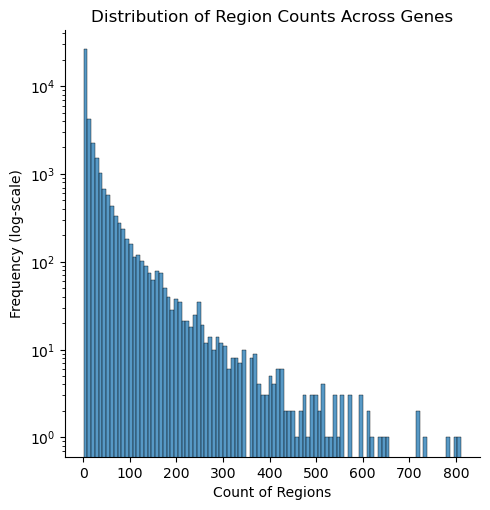

In [94]:
plt.figure(figsize=(12, 6))
sns.displot(df["count"], kind='hist', log_scale=(False, True), bins=100)
plt.xlabel("Count of Regions")
plt.ylabel("Frequency (log-scale)")
plt.title("Distribution of Region Counts Across Genes")
plt.show()

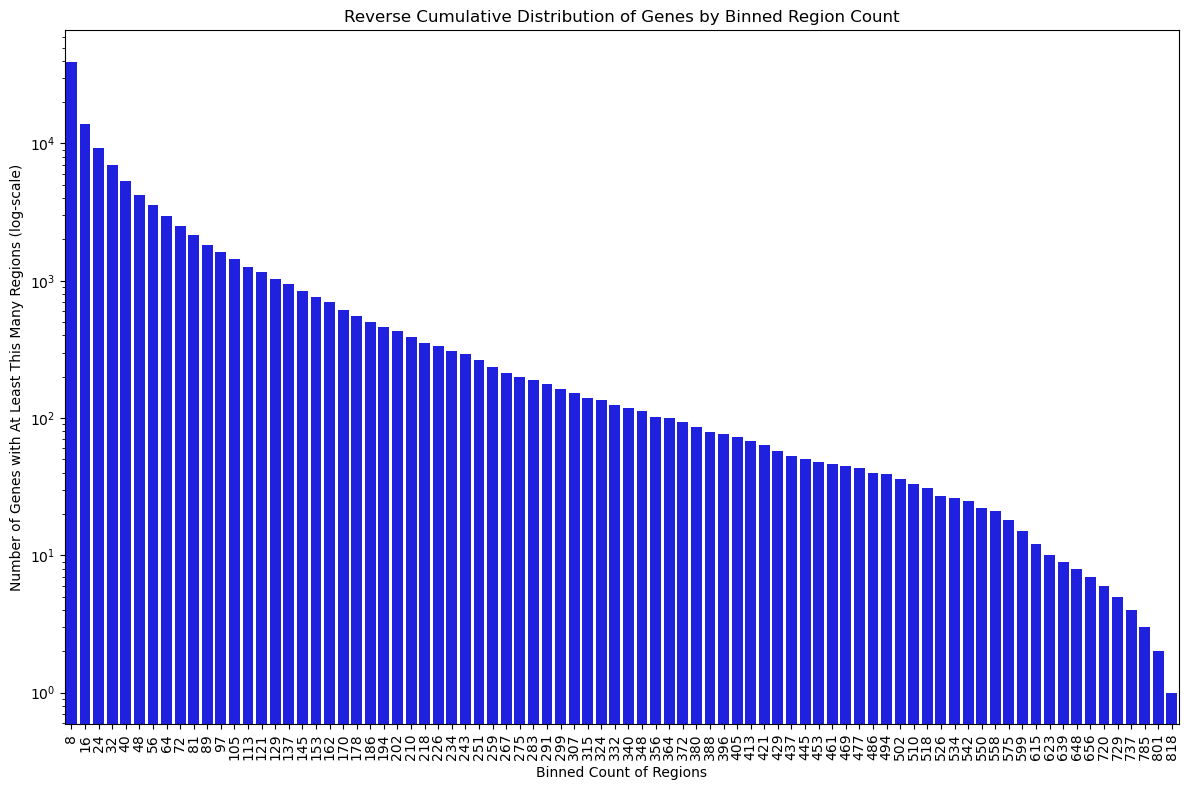

In [95]:
bin_count = 100  # Adjust the number of bins as needed

# Calculate the bin size based on the data range and desired bin count
max_count = df['count'].max()
min_count = df['count'].min()
bin_size = (max_count - min_count) / bin_count
df['binned'] = np.ceil(df['count'] / bin_size) * bin_size

# Group by the binned column and calculate the reverse cumulative count
binned_df = df.groupby('binned').size().reset_index(name='gene_count')
binned_df = binned_df.sort_values(by='binned', ascending=False)
binned_df['reverse_cumulative_count'] = binned_df['gene_count'].cumsum()

# Convert the 'binned' column to integer for better labeling
binned_df['binned'] = binned_df['binned'].astype(int)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=binned_df['binned'], y=binned_df['reverse_cumulative_count'], color="blue")
plt.xticks(rotation=90)
plt.xlabel("Binned Count of Regions")
plt.ylabel("Number of Genes with At Least This Many Regions (log-scale)")
plt.yscale('log')
plt.title("Reverse Cumulative Distribution of Genes by Binned Region Count")
plt.tight_layout()
plt.show()

## 8. Plot Count of Cells per Gene

In [96]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

In [97]:
adata.var

,transcript_annotation,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
index,,,,,,,
chr1:9955-10355,DDX11L1,226,0.037738,0.037043,97.944894,415.0,6.030685
chr1:29163-29563,WASH7P;MIR1302-11,3,0.000364,0.000364,99.972720,4.0,1.609438
chr1:79215-79615,intergenic,0,0.000000,0.000000,100.000000,0.0,0.000000
chr1:102755-103155,RP11-34P13.7,0,0.000000,0.000000,100.000000,0.0,0.000000
chr1:180580-180980,intergenic,182,0.032827,0.032300,98.345003,361.0,5.891644
...,...,...,...,...,...,...,...
chrY:56676947-56677347,unassigned,0,0.000000,0.000000,100.000000,0.0,0.000000
chrY:56677442-56677842,unassigned,4,0.000364,0.000364,99.963626,4.0,1.609438
chrY:56678029-56678429,unassigned,11,0.001000,0.001000,99.899973,11.0,2.484907


In [98]:
df2 = pd.DataFrame({
    'gene': adata.var["transcript_annotation"],
    'cell_count': adata.var["n_cells_by_counts"]
})

df2 = df2.groupby('gene')['cell_count'].sum().reset_index()
df2.columns = ['gene', 'count']
df2.set_index('gene', inplace=True)

In [99]:
df2

,count
gene,
7SK,1319
A1CF,488
A1CF;ASAH2B,17
A2M,166
A2ML1,1306
...,...
hsa-mir-7162,529
hsa-mir-7162;RP11-299H22.5,25
hsa-mir-7515,245


In [100]:
print(f'intergenic: {df2.loc["intergenic"]["count"]}')
print(f'unassigned: {df2.loc["unassigned"]["count"]}')

intergenic: 13273557
unassigned: 828


In [101]:
# Drop 'intergenic' and 'unassigned' annotations
df2 = df2.drop("intergenic")
df2 = df2.drop("unassigned")

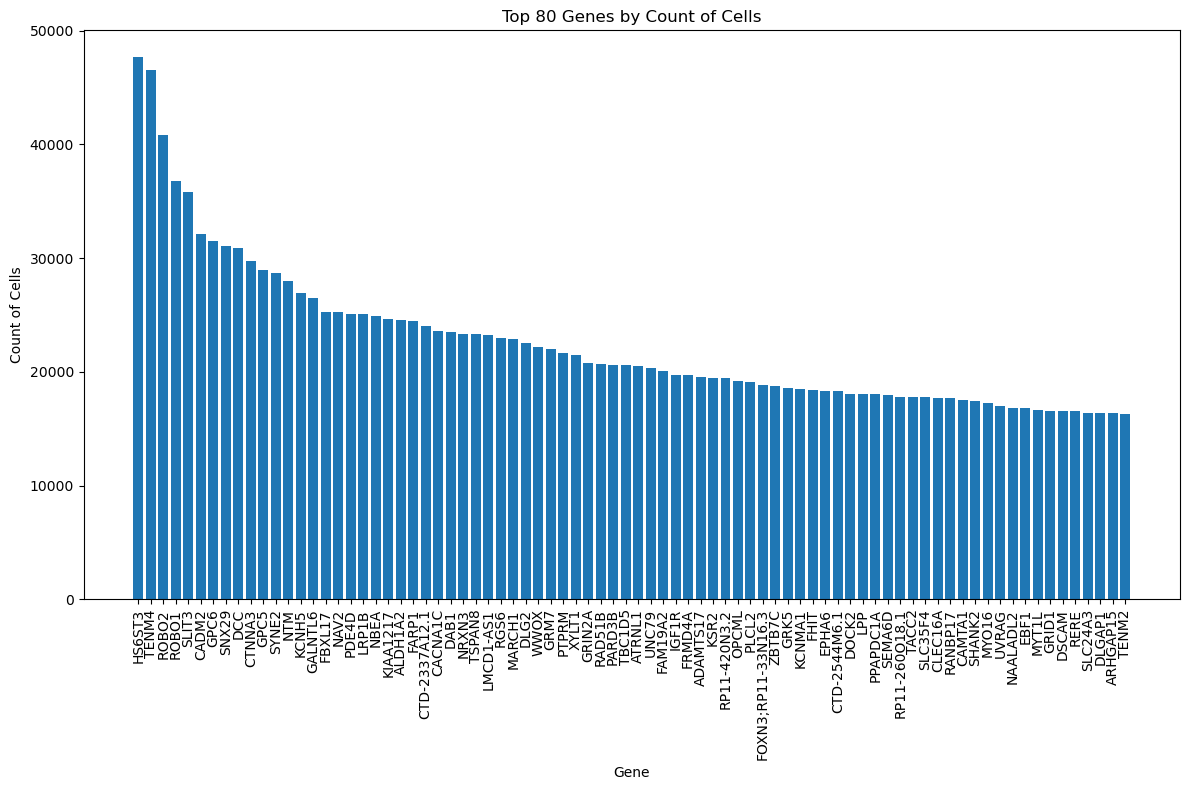

In [102]:
top_n = 80  # Adjust this number as needed
sorted_df2 = df2.sort_values(by="count", ascending=False).head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(sorted_df2.index, sorted_df2["count"])
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Count of Cells")
plt.title(f"Top {top_n} Genes by Count of Cells")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

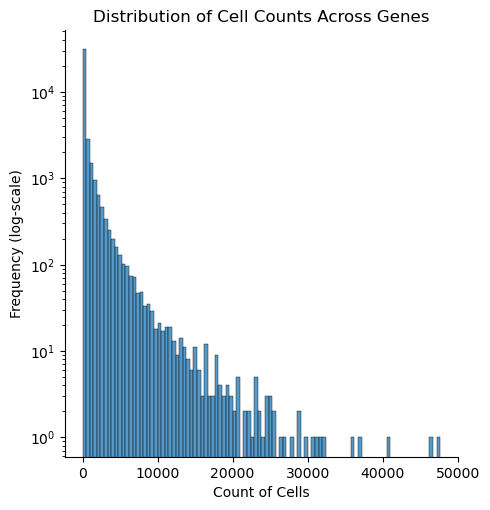

In [103]:
plt.figure(figsize=(12, 6))
sns.displot(df2["count"], kind='hist', log_scale=(False, True), bins=100)
plt.xlabel("Count of Cells")
plt.ylabel("Frequency (log-scale)")
plt.title("Distribution of Cell Counts Across Genes")
plt.show()

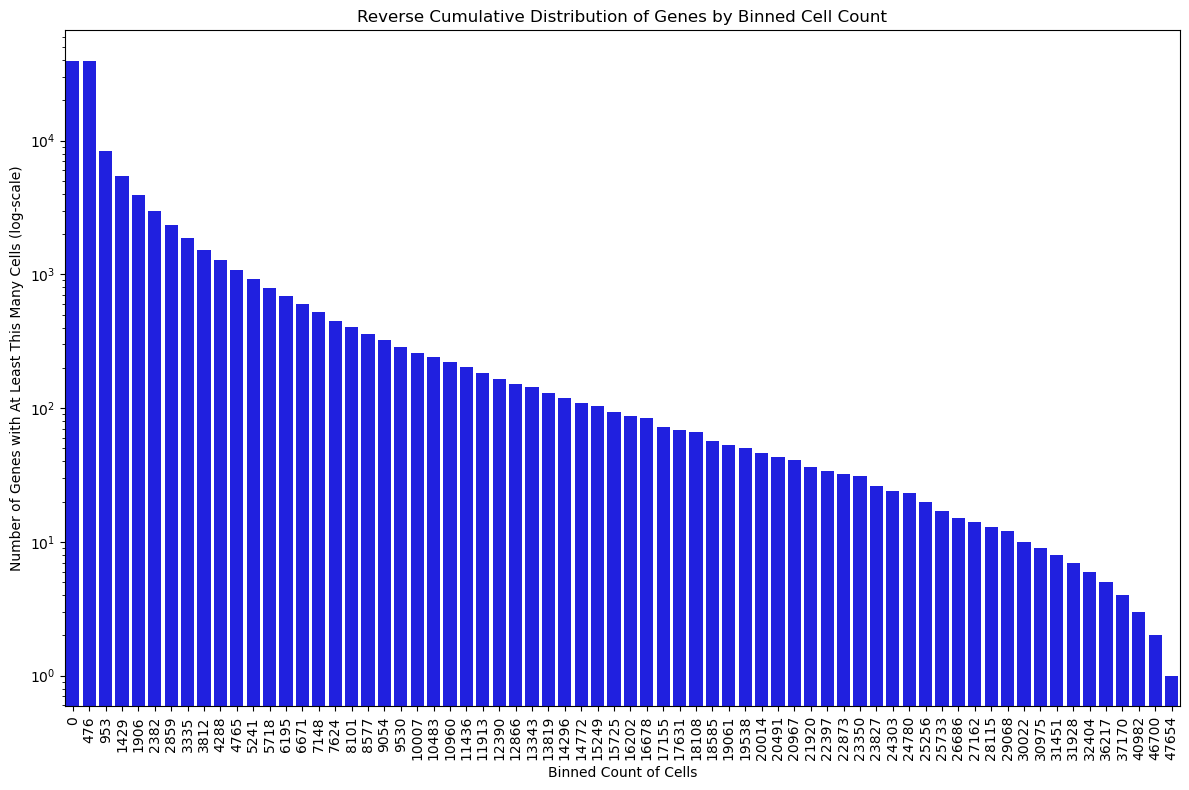

In [104]:
bin_count = 100  # Adjust the number of bins as needed

# Calculate the bin size based on the data range and desired bin count
max_count = df2['count'].max()
min_count = df2['count'].min()
bin_size = (max_count - min_count) / bin_count
df2['binned'] = np.ceil(df2['count'] / bin_size) * bin_size

# Group by the binned column and calculate the reverse cumulative count
binned_df = df2.groupby('binned').size().reset_index(name='gene_count')
binned_df = binned_df.sort_values(by='binned', ascending=False)
binned_df['reverse_cumulative_count'] = binned_df['gene_count'].cumsum()

# Convert the 'binned' column to integer for better labeling
binned_df['binned'] = binned_df['binned'].astype(int)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=binned_df['binned'], y=binned_df['reverse_cumulative_count'], color="blue")
plt.xticks(rotation=90)
plt.xlabel("Binned Count of Cells")
plt.ylabel("Number of Genes with At Least This Many Cells (log-scale)")
plt.yscale('log')
plt.title("Reverse Cumulative Distribution of Genes by Binned Cell Count")
plt.tight_layout()
plt.show()

**Note**: There are a lot of Regions without Cells.
Thus there are a lot of Genes without Cells

In [105]:
genes_without_cells = len(df2[df2["count"] < 1])
print(f"Genes without Cells: {genes_without_cells}")

Genes without Cells: 119
